In [119]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/restaurant-reviews/Restaurant reviews.csv


In [120]:
# Installing weights and bias
!pip install -qqq wandb datasets transformers

In [121]:
#import required libraries
import torch 
import wandb
import sys
from pathlib import Path
from datasets import load_dataset, Dataset
from torch import tensor,nn,device,cuda
from transformers import AutoTokenizer, TrainingArguments, Trainer,AutoModelForSequenceClassification,DataCollatorWithPadding
from transformers.trainer_callback import EarlyStoppingCallback,TrainerCallback
from huggingface_hub import HfFolder
from datasets import load_metric
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import load_dataset,Dataset,load_metric
import tensorflow as tf

Log in to huggingface and w&b

In [122]:
!pip install huggingface_hub

In [123]:
from huggingface_hub import login

login()

In [124]:
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

my_secret = user_secrets.get_secret("wandb_api_key") 

import wandb
wandb.login(key=my_secret)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

Set up weight and bias parameters


In [125]:
PROJECT_NAME="restaurant_review"
DATASET_TYPE='dataset'
MODEL_TYPE='model'

#wandb job types
RAW_DATA_JOB_TYPE='fetch_raw_data'
DATA_PROCESSING_JOB_TYPE='preocess-data'
SPLIT_DATA_JOB_TYPE='split-data'
MODEL_TRAINING_JOB_TYPE='model-training'
MODEL_INFERENCE_JOB_TYPE='model-inference'

#Wandb artifact names
RAW_DATA_ARTIFACT='restaurant_raw_data'
PROCESSED_DATA_ARTIFACT='processed_data'
TRAIN_DATA_ARTIFACT='restaurant_train_data'
TEST_DATA_ARTIFACT='restaurant_test_data'

#data folders
RAW_DATA_FOLDER='restaurent-dataset/raw'
PROCESSED_DATA_FOLDER='restaurant-dataset/processed'
TRAIN_DATA_FOLDER='restaurant-dataset/train'
TEST_DATA_FOLDER='restaurant-dataset/test'
MODEL_DATA_FOLDER='restaurant-dataset/model'

# TRANSFORMERS PARAMETERS
MODEL_NAME = "distilbert-base-uncased"
NUM_EPOCHS = 3
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 32
WARMUP_STEPS = 500
LEARNING_RATE = 5e-5
FP16 = True
# HUB PARAMETERS
PUSH_TO_HUB = True
HUB_MODEL_ID = "distilbert-complaints-wandb-product"
HUB_STRATEGY = "every_save"

Download and log rawdata

In [126]:
run=wandb.init(project=PROJECT_NAME,job_type='Baseline modeling',save_code=True)


wandb: WARNING Source type is set to 'artifact' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [127]:
original_data='/kaggle/input/restaurant-reviews/Restaurant reviews.csv'


#text_dataset=load_dataset(original_data)

EDA


In [128]:
#Read in data
rest=pd.read_csv(original_data)

rest.head()

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,7514
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0,2447.0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0,NaN
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0,NaN
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0,NaN
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0,NaN


In [129]:
print(rest.info())
rest.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Restaurant  10000 non-null  object 
 1   Reviewer    9962 non-null   object 
 2   Review      9955 non-null   object 
 3   Rating      9962 non-null   object 
 4   Metadata    9962 non-null   object 
 5   Time        9962 non-null   object 
 6   Pictures    10000 non-null  int64  
 7   7514        1 non-null      float64
dtypes: float64(1), int64(1), object(6)
memory usage: 625.1+ KB
None


Index(['Restaurant', 'Reviewer', 'Review', 'Rating', 'Metadata', 'Time',
       'Pictures', '7514'],
      dtype='object')

In [130]:
rest.shape

(10000, 8)

In [131]:
rest['Rating'].value_counts()

Rating
5       3832
4       2373
1       1735
3       1193
2        684
4.5       69
3.5       47
2.5       19
1.5        9
Like       1
Name: count, dtype: int64

In [132]:
rest=rest.drop(rest[rest['Rating']=='Like'].index)
#df = df.drop(df[(df.score < 50) & (df.score > 20)].index)
rest.shape

(9999, 8)

In [133]:
rest['Rating']=pd.to_numeric(rest['Rating'])
rest.columns

Index(['Restaurant', 'Reviewer', 'Review', 'Rating', 'Metadata', 'Time',
       'Pictures', '7514'],
      dtype='object')

In [134]:
# Round ratings to nearest digit.
rest['Rating'].replace(1.5,2,inplace=True)
rest['Rating'].replace(2.5,3,inplace=True)
rest["Rating"].replace(3.5,4,inplace=True)
rest["Rating"].replace(4.5,5,inplace=True)

In [135]:
rest['Rating'].value_counts()

Rating
5.0    3901
4.0    2420
1.0    1735
3.0    1212
2.0     693
Name: count, dtype: int64

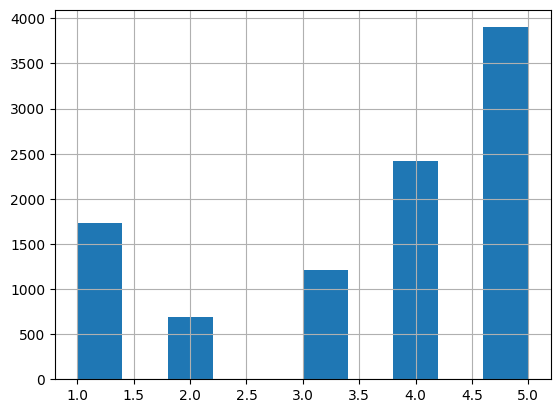

In [136]:
#check all ratings
#It seems its an imbalanced dataset with max records as 5 ratings.
import matplotlib.pyplot as plt
rest['Rating'].astype(float).hist()
plt.show()

In [137]:
# Create and log original dataset
raw_artifact=wandb.Artifact(RAW_DATA_ARTIFACT,type=DATASET_TYPE)
#raw_artifact.add_dir(RAW_DATA_FOLDER)
run.log_artifact(raw_artifact)
run.finish()

In [138]:
#drop 7514 column
rest.drop(['7514'],axis=1,inplace=True)
rest.shape

(9999, 7)

Log data as Table in WANDB

In [139]:
wandb.init(project=PROJECT_NAME,name="tables")

wandb.log({"table":wandb.Table(data=rest,columns=['Restaurant','Review','Rating'])})
wandb.finish()

wandb: WARNING Source type is set to 'artifact' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Process and log data


In [140]:
run=wandb.init(project=PROJECT_NAME,job_type=DATA_PROCESSING_JOB_TYPE)

#by using use_artifact we are logging to w*b and can track it as part of the lineage
run.use_artifact(f'{RAW_DATA_ARTIFACT}:latest')



<Artifact QXJ0aWZhY3Q6NTg5OTA0NjAx>

In [141]:
#Check for any missing values 
rest[rest.isna().any(axis=1)].head()


,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures
2360,Amul,Lakshmi Narayana,NaN,5.0,0 Reviews,7/29/2018 18:00,0
5799,Being Hungry,Surya,NaN,5.0,"4 Reviews , 4 Followers",7/19/2018 23:55,0
6449,Hyderabad Chefs,Madhurimanne97,NaN,5.0,1 Review,7/23/2018 16:29,0
6489,Hyderabad Chefs,Harsha,NaN,5.0,1 Review,7/8/2018 21:19,0
7954,Olive Garden,ARUGULLA PRAVEEN KUMAR,NaN,3.0,"1 Review , 1 Follower",8/9/2018 23:25,0


In [142]:
rest.isna().sum()

Restaurant     0
Reviewer      38
Review        45
Rating        38
Metadata      38
Time          38
Pictures       0
dtype: int64

In [143]:
#It seems there are many missing values in Review columns ,which will not help in modeling 
# LEts remove missing reviews
rest['Review'].dropna(inplace=True)
rest.shape
rest=rest.drop(rest[rest['Review'].isna()].index)
rest.shape

(9954, 7)

In [144]:
rest.isna().sum()

Restaurant    0
Reviewer      0
Review        0
Rating        0
Metadata      0
Time          0
Pictures      0
dtype: int64

In [145]:
#Check duplicate values
rest['Review'].duplicated().sum()

591

In [146]:
#drop duplicates in review columns
rest=rest.drop_duplicates(['Restaurant','Review'],keep='last')
rest.shape

(9688, 7)

In [154]:
# Splitting the dataset into training and validation set
cols=['Review' ,'Restaurant']
X=rest['Review']
y=rest['Rating']
#X.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))
X.head()

0    The ambience was good, food was quite good . h...
1    Ambience is too good for a pleasant evening. S...
2    A must try.. great food great ambience. Thnx f...
3    Soumen das and Arun was a great guy. Only beca...
4    Food is good.we ordered Kodi drumsticks and ba...
Name: Review, dtype: object

#There may be special characters and emojis in review.

#Lets check if there are any emojis in the text.

#Lets check in ChatGPT if we find any validated code to check emojis and to remove that.

I have passed following prompt to ChatGPT.

"You are an expert data scientist. Please solve my problem.
I have a pandas series with restaurant reviews. Some reviews contain emojis. I want to remove print reviews containing emojis.
Show me python code or pandas code to achieve this."

I got following code. Lets check code.

In [155]:
import pandas as pd
import re

# Function to check if a string contains emojis
def contains_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    return bool(emoji_pattern.search(text))

# Filter reviews containing emojis
X_emojis = X[X.apply(contains_emoji)]



In [156]:
X_emojis.head()

21    please was good but it was quite expensive and...
25    The place is very good.. 5* to the live music....
26    Sonalin has a great voice.. 😍 must visit the p...
27    I heard her voice..she is too beautiful with a...
28    Sonalin is a very good singer in the city.. be...
Name: Review, dtype: object

In [157]:
#Lets check first example to see which emojis are there.
X_emojis[21]

'please was good but it was quite expensive and coming to taste we can rate 3 out of 5, we cant click better pictures wen we visit in night🤣🤭best in day time for pics'

#Lets check in ChatGPT if we find any validated code to remove that.

I have passed following prompt to ChatGPT.

"You are an expert data scientist. Please solve my problem.
I have a pandas series with restaurent reviews. Some reviews contain emojis. I want to remove emojis from each text that contains it.
Sometimes its attached with word so it becomes part of a word. In such cases ,I want to  remove only emojis and not the whole word.
Show me python code or pandas code to achieve this."

I got following code. Lets check code.

In [159]:

# Function to remove emojis from a text while preserving attached words
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Apply the function to remove emojis from restaurant reviews
X_e = X.apply(remove_emojis)

# Print the reviews without emojis
print(X_e)

0       The ambience was good, food was quite good . h...
1       Ambience is too good for a pleasant evening. S...
2       A must try.. great food great ambience. Thnx f...
3       Soumen das and Arun was a great guy. Only beca...
4       Food is good.we ordered Kodi drumsticks and ba...
                              ...                        
9995    Madhumathi Mahajan Well to start with nice cou...
9996    This place has never disappointed us.. The foo...
9997    Bad rating is mainly because of "Chicken Bone ...
9998    I personally love and prefer Chinese Food. Had...
9999    Checked in here to try some delicious chinese ...
Name: Review, Length: 9688, dtype: object


In [160]:
#Check same example again.
X_e[21]

'please was good but it was quite expensive and coming to taste we can rate 3 out of 5, we cant click better pictures wen we visit in nightbest in day time for pics'

In [171]:
X_e.shape

(9688,)

In [161]:
X_train,X_test,y_train,y_test=train_test_split(X_e,y,test_size=0.2,random_state=42,stratify=y)

In [170]:
print(X_train.shape)
print(y_train.shape)
print(X_train.head())
print(y_train.head())

(7750,)
(7750,)
7732    It's very nice experiance. Very good environme...
9931    I have been to this place about 6/7 times. I a...
8732    I've ordered chicken wings and french fries. T...
368     Worst food received, low quality rice was used...
4422    They have a good amount of space with decent a...
Name: Review, dtype: object
7732    5.0
9931    4.0
8732    1.0
368     1.0
4422    4.0
Name: Rating, dtype: float64


In [172]:
#Divide training data to further training and val sets . USe test data for prediction
X_tr,X_val,y_tr,y_val=train_test_split(X_train,y_train,test_size=0.2,random_state=42,stratify=y_train)

In [173]:
# Set hyperparameters for baseline model
vocab_size=10000
embedding_dim=16
max_length=120
trunc_type='post'
padding_type='post'
oov_tok='<OOV>'



In [165]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [174]:
#Get tokenizer
tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(X_tr)
word_index=tokenizer.word_index

training_sequences=tokenizer.texts_to_sequences(X_tr)
val_sequences=tokenizer.texts_to_sequences(X_val)
train_padded=pad_sequences(training_sequences,maxlen=max_length,padding=padding_type,truncating=trunc_type)
val_padded=pad_sequences(val_sequences,maxlen=max_length,padding=padding_type,truncating=trunc_type)

In [175]:
print(train_padded[1])
print(val_padded[1])


[143  30  48   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]
[393 143 313  13 111   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]


In [176]:
testing_sequences=tokenizer.texts_to_sequences(X_test)
testing_padded=pad_sequences(testing_sequences,maxlen=max_length,padding=padding_type,truncating=trunc_type)

In [177]:
print(testing_padded[1])


[  26 1602  198  719    2  737    3  699    3 3111   30  308   63 2640
   17 6898  278  647   39    2  501  314   15   12   61   26  160  885
   17 1602  162  480   81    1   16  409    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [178]:
model=tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24,activation='relu'),
    tf.keras.layers.Dense(6,activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_6 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 24)                1560      
                                                                 
 dense_13 (Dense)            (None, 6)                 150       
                                                                 
Total params: 174,254
Trainable params: 174,254
Non-trainable params: 0
_________________________________________________________________
None


In [180]:
num_epochs=10

training_padded=np.array(train_padded)
training_labels=np.array(y_train)
testing_padded=np.array(testing_padded)
testing_labels=np.array(y_test)

history=model.fit(training_padded,
                  y_tr,
                  epochs=num_epochs,
                  validation_data=(val_padded, y_val),
                  verbose=1)

Epoch 1/10
194/194 [==============================] - 13s 51ms/step - loss: 1.4787 - accuracy: 0.3961 - val_loss: 1.3159 - val_accuracy: 0.4723
Epoch 2/10
194/194 [==============================] - 9s 48ms/step - loss: 1.0372 - accuracy: 0.5929 - val_loss: 1.0002 - val_accuracy: 0.5781
Epoch 3/10
194/194 [==============================] - 9s 48ms/step - loss: 0.7959 - accuracy: 0.6844 - val_loss: 0.8933 - val_accuracy: 0.6123
Epoch 4/10
194/194 [==============================] - 9s 48ms/step - loss: 0.6706 - accuracy: 0.7385 - val_loss: 0.9278 - val_accuracy: 0.6187
Epoch 5/10
194/194 [==============================] - 9s 47ms/step - loss: 0.5631 - accuracy: 0.7898 - val_loss: 1.0763 - val_accuracy: 0.6155
Epoch 6/10
194/194 [==============================] - 9s 48ms/step - loss: 0.4789 - accuracy: 0.8255 - val_loss: 1.0639 - val_accuracy: 0.6052
Epoch 7/10
194/194 [==============================] - 9s 46ms/step - loss: 0.4064 - accuracy: 0.8579 - val_loss: 1.2350 - val_accuracy: 0.571

Plot accuracy and losses

/tmp/ipykernel_32/2969918133.py:7: UserWarning: The label '_' of 'u' starts with '_'. It is thus excluded from the legend.
  plt.legend(string,'val_'+string)
/tmp/ipykernel_32/2969918133.py:7: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend(string,'val_'+string)


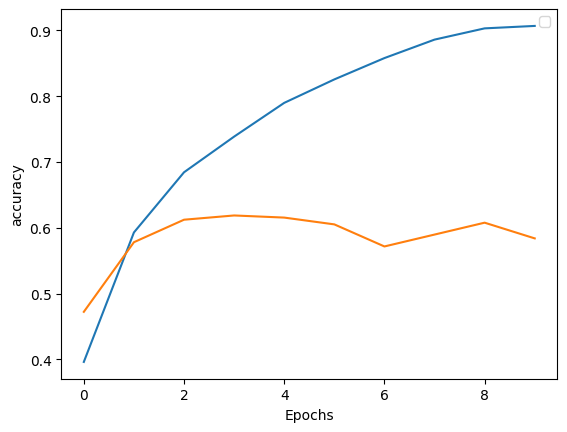

/tmp/ipykernel_32/2969918133.py:7: UserWarning: The label '_' of 's' starts with '_'. It is thus excluded from the legend.
  plt.legend(string,'val_'+string)


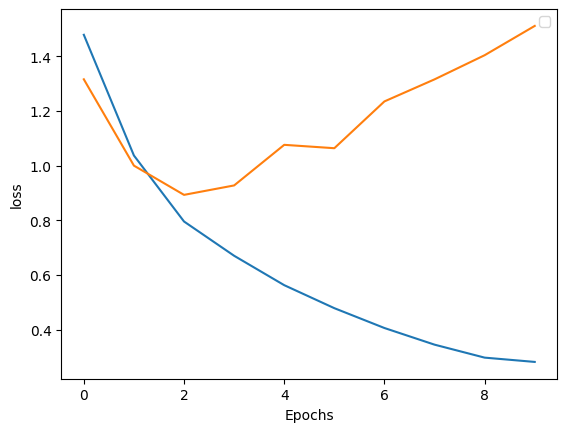

In [184]:
import matplotlib.pyplot as plt
def plot_graphs(history,string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend(string,'val_'+string)
    plt.show()

plot_graphs(history,'accuracy')
plot_graphs(history,'loss')